<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/03_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# Machine Learning Model: regression
| | |
|------|------|
| Filename | 03_regression.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 8, 2024 |
| Aim(s) | Do regression tasks with a neural network machine learning model|
| Dataset(s) | Auto MPG dataset from UC Irvine [[1]](https://archive.ics.uci.edu/dataset/9/auto+mpg) |
| Version | Python 3.12 |


<br> **!!Read before running!!** <br>
1. CPU execution is enough
2. Run all and read comments.

---

## 1. Import libraries & prebuilt dataset

This Python script builds a **neural network** (NN) to perform regression tasks. The objective is to predict the output of a continuous value. With the Auto MPG datase from the UC Irvine university [[1]](https://archive.ics.uci.edu/dataset/9/auto+mpg), the neural network has to predict **fuel efficiency** of any 1970s / 1980s automobiles. For this, descriptions of many automobile from that period are provided.

In [ ]:
import numpy as np # scientific computing
import pandas as pd # data structures and data analysis tools
import tensorflow as tf # machine learning models
import plotly.express as px # graphing packages

**Comments**
<br> Variables from Auto MPG dataset (9 var x 398 inst)

*   displacement
*   mpg
*   cylinders
*   horsepower (missing values)
*   weight
*   acceleration
*   model_year
*   origin
*   car_name

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'] # MPG = fuel efficiency

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 2. Pre-processing & sample preparation

**Comments**
<br> Origin category is modified to show name countries

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}) # convert origin label by name of the origin country
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


**Comments**
<br> Now, the dataset is split into 2 subsets: training (80%) and test (20%) [[2]](https://arxiv.org/pdf/2202.03326). Test set is used for a finale evaluation of the model.

In [ ]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index) # removes the rows selected for the training set from the original dataset
fig = px.scatter(x=train_dataset['Horsepower'], y=train_dataset['MPG'], width=600, height=400)
fig.update_xaxes(title="Horsepower"), fig.update_layout(showlegend=False), fig.update_yaxes(title="MPG")
fig.show()

**Comments**
<br> Separate features (=displacement) and labels (=MPG) of the training set. Then, a pre-processing layer that normalizes input data is created. Th efuel efficiency `MPG` is predicted from `Horsepower` values.

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower) # fit to the data to compute the mean and standard deviation

## 3. Training step with a linear regression model



**Comments**
<br> Some values of `Horsepower` are missing. Therefore, linear regression is done with a simple neural network model (standardization layer + dense layer of 1 output).

In [ ]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer, tf.keras.layers.Dense(units=1)])
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


array([[ 0.8693763 ],
       [ 0.49099976],
       [-1.6046242 ],
       [ 1.2186469 ],
       [ 1.1022234 ],
       [ 0.43278795],
       [ 1.3059647 ],
       [ 1.1022234 ],
       [ 0.28725854],
       [ 0.49099976]], dtype=float32)

In [ ]:
%%time
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')
history = horsepower_model.fit(train_features['Horsepower'], train_labels, epochs=100, verbose=0, validation_split = 0.2)

CPU times: user 7.06 s, sys: 279 ms, total: 7.34 s
Wall time: 10.1 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.902441,3.575970,95
96,3.903724,3.552229,96
97,3.906319,3.565584,97
98,3.902010,3.597188,98
99,3.902147,3.568259,99


In [ ]:
def plot_loss(history):
  fig = px.line(history.history['loss'], labels={'loss'}, width=600, height=400)
  fig2 = px.scatter(history.history['val_loss'], labels={'val_loss'})
  fig.add_trace(fig2.data[0])
  newnames = {'0':'loss', '0': 'val_loss'}
  fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name], hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
  fig.update_xaxes(title="Epoch"), fig.update_traces(showlegend=True), fig.update_yaxes(title="Error MPG")
  fig.show()

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
def plot_horsepower(x, y):
  fig = px.line(x=x, y=y[:,0], labels={'predictions'}, width=600, height=400)
  fig2 = px.scatter(x=train_features['Horsepower'], y=train_labels, labels={'Data'})
  fig.add_trace(fig2.data[0])
  fig.update_xaxes(title="Horsepower"), fig.update_layout(showlegend=True), fig.update_yaxes(title="MPG")
  fig.show()


  # plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  # plt.plot(x, y, color='k', label='Predictions')
  # plt.xlabel('Horsepower')
  # plt.ylabel('MPG')
  # plt.legend()

In [ ]:
plot_horsepower(x, y)

## 4. Training step with linear regression with multiple inputs model

In [ ]:
linear_model = tf.keras.Sequential([normalizer,tf.keras.layers.Dense(units=1)])
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([[-0.52110744],
       [ 0.59455013],
       [ 2.0238447 ],
       [ 0.18978143],
       [-2.0478396 ],
       [ 0.63528156],
       [-2.3135896 ],
       [-0.7784214 ],
       [ 0.3508037 ],
       [-2.5060024 ]], dtype=float32)

In [ ]:
%%time
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')
history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split = 0.2)

CPU times: user 6.88 s, sys: 262 ms, total: 7.14 s
Wall time: 8.12 s


In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([norm, tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(64, activation='relu'), tf.keras.layers.Dense(1)])

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.9 s, sys: 294 ms, total: 8.19 s
Wall time: 11.1 s


In [ ]:
plot_loss(history)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
plot_horsepower(x, y)

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## 5. Training step with a Deep Neural Network model (DNN)

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (314, 9)                    │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [ ]:
%%time
history = dnn_model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)
plot_loss(history)

CPU times: user 8.06 s, sys: 301 ms, total: 8.36 s
Wall time: 10.2 s


In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6161


In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646294
linear_model,2.439286
dnn_horsepower_model,3.063690
dnn_model,1.723237


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


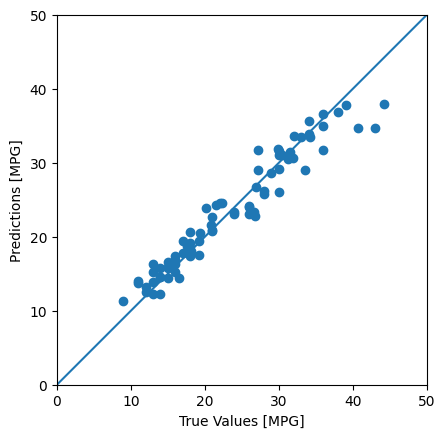

In [ ]:
import matplotlib.pyplot as plt

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

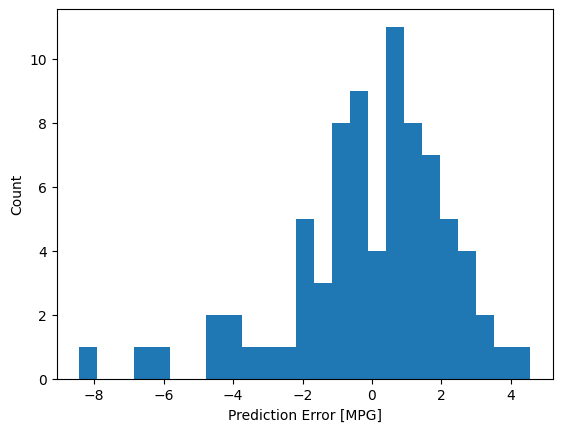

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646294
linear_model,2.439286
dnn_horsepower_model,3.063690
dnn_model,1.723237
